# Sentiment Analysis and Topic Modeling on Tweets about Online Education during COVID-19

## Importing Libraries

In [4]:
#pip install vaderSentiment
!pip install plotly

     |████████████████████████████████| 25.3 MB 7.6 MB/s eta 0:00:01


In [5]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

[nltk_data] Downloading package stopwords to /Users/ab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the Dataset

In [6]:
f=pd.read_csv("onlinelearning_cleaned_data_latest.csv")


In [7]:
f.columns


Index(['Unnamed: 0', 'ID', 'Date', 'Tweet'], dtype='object')

In [8]:
copy=f.copy()

In [9]:
Time=[]
for index,date in enumerate(copy.Date):
    collect=(str(date)).split()
    copy.at[index,'Date']=collect[0]
    Time.append(collect[1])

In [10]:
copy["Time"]=Time

In [11]:
copy.head(10)

,Unnamed: 0,ID,Date,Tweet,Time
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00
5,120,1454387602862264344,2021-10-30,The ability to converse in another language is...,10:00:00+00:00
6,144,1454326056769363977,2021-10-30,Lots of students in Discord this semester. The...,05:55:26+00:00
7,146,1454320389388046339,2021-10-30,What are your current learning practices?,05:32:55+00:00
8,153,1454297018755686405,2021-10-30,there is a museum dedicated to failure. Displa...,04:00:03+00:00
9,154,1454289410258718727,2021-10-30,"So, ofcourse the internet connection dies in l...",03:29:49+00:00


In [12]:
#Kept all tweets, assuming that the same tweet at same time may be written by 2 different prople
#copy = copy.drop_duplicates(subset=['Date','Tweet'], keep="first")

In [13]:
len(copy)

28091

In [14]:
len(f)

28091

In [15]:
stopwords=stop_words=stopwords.words("english")

In [16]:
copy.Tweet

0        All Green STARS on ! Every lesson, every unit!...
1        each week and then pass over to the children T...
2            Why did you consider a profession of teacher?
3        Read from ALL sources Remember, the test will ...
4        Answer ALL questions There is no negative mark...
                               ...                        
28086    Into the world of remote online Learning due t...
28087    Many teachers in Ontario are using asynchronou...
28088    Closed b/c of COVID-19? Check out FB group "In...
28089            So agree with you. It’s all about journey
28090    Calsouthern let's you start your courses anyti...
Name: Tweet, Length: 28091, dtype: object

In [17]:
copy=copy.dropna()

## PreProcessing Data

In any machine learning task, cleaning the data is as important as model building if not more. And when it comes to unstructured data like text, this process is even more important.

To this end , I will perform some cleansing activities as pre-processing steps beforehand model building:

- Lowercase text
- Remove stop words and punctuations and most common words
- Once our data does not contain any unwanted characters, we will perform Lemmatization to reduce inflected words to their root words.


In [18]:
## English Stopwords 
stop = nltk.corpus.stopwords.words('english')

## Most_common words
most_common_words = ['online','student','school','learn','education']


## Preprocessing the data
def clean(doc):
    lowercase=[i.lower() for i in nltk.word_tokenize(doc) if i.lower() not in stop and i.isalpha()]
    wordnet_lemmatizer = WordNetLemmatizer()
    normalized=[wordnet_lemmatizer.lemmatize(i) for i in lowercase]
    tokens = [i.lower() for i in normalized if i.lower() not in most_common_words]
    return tokens

## Adding cleaned data in the dataframe               
clean_tweet = []

for doc in copy['Tweet']:
    clean_tweet.append(clean(str(doc))) 

copy['clean_tweet'] = clean_tweet

In [19]:
copy.head()

,Unnamed: 0,ID,Date,Tweet,Time,clean_tweet
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00,"[green, star, every, lesson, every, unit, going]"
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00,"[week, pas, child, take, turn, talk, reading, ..."
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00,"[consider, profession, teacher]"
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00,"[read, source, remember, test, text, various, ..."
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00,"[answer, question, negative, marking, make, su..."


In [20]:
copy.isna().sum().sum()

0

In [21]:
copy=copy.dropna()

In [22]:
copy.isna().sum().sum()

0

In [23]:
#contain_values=copy[copy["Tweet"].str.contains("8 days and 8 hours")]
#len(contain_values)

## Exploratory Data Analysis

### Tweets length

/Users/ab/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


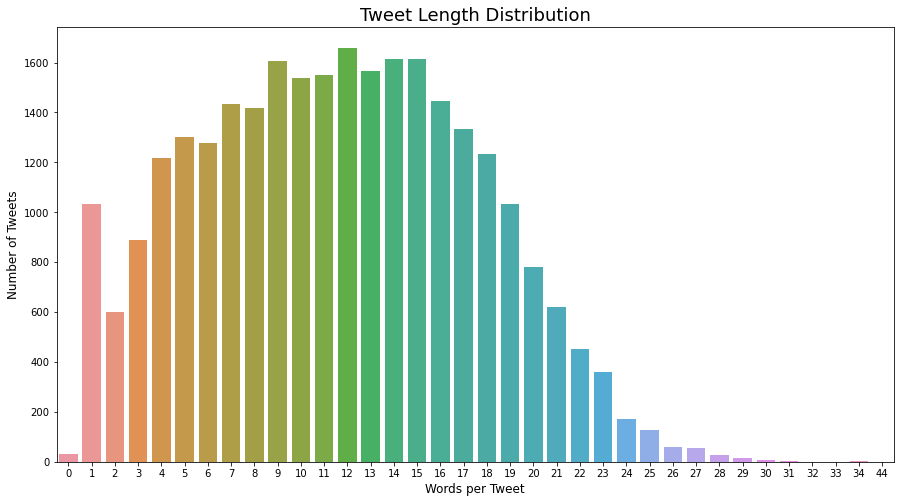

In [24]:
tweet_lengths = [len(tokens) for tokens in copy['clean_tweet']]
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

### Wordcloud

In [25]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in copy['clean_tweet'] for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(50)

[('learning', 4637),
 ('class', 3008),
 ('amp', 2859),
 ('teacher', 2341),
 ('time', 2317),
 ('course', 2041),
 ('day', 1970),
 ('today', 1784),
 ('need', 1753),
 ('u', 1700),
 ('help', 1688),
 ('work', 1662),
 ('get', 1656),
 ('one', 1624),
 ('like', 1514),
 ('kid', 1487),
 ('thank', 1487),
 ('teaching', 1485),
 ('week', 1483),
 ('new', 1450),
 ('know', 1377),
 ('year', 1359),
 ('make', 1238),
 ('great', 1187),
 ('first', 1047),
 ('way', 1045),
 ('would', 1040),
 ('good', 1022),
 ('video', 1011),
 ('use', 958),
 ('please', 945),
 ('lesson', 941),
 ('home', 925),
 ('many', 918),
 ('thing', 898),
 ('see', 869),
 ('much', 869),
 ('going', 864),
 ('best', 853),
 ('want', 816),
 ('looking', 815),
 ('well', 814),
 ('child', 810),
 ('go', 800),
 ('take', 786),
 ('parent', 785),
 ('support', 781),
 ('think', 774),
 ('zoom', 773),
 ('back', 760)]

In [26]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(50)]
most_common_word = [x[0] for x in word_freq.most_common(50)]

#create dictionary mapping of word count
top_50_dictionary = dict(zip(most_common_word, most_common_count))

In [27]:
from wordcloud import WordCloud

#Create Word Cloud of top 100 words
# round_mask = np.array(Image.open( "rhombus.png"))
wordcloud = WordCloud(colormap = 'RdYlGn', background_color = 'white', mask = None)\
.generate_from_frequencies(top_50_dictionary)

#plot with matplotlib
plt.figure(figsize=(14, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_50_cloud.png')

plt.show()

ModuleNotFoundError: No module named 'wordcloud'

As depicted in above figure, words like ‘learning’, ‘online’, ‘class’, ‘education’ and ‘schools’, ‘teacher’ were frequently used. Out of these words, ‘learning’, ‘student’, ‘online’ and ‘time’, got the most considerable number of words used. Correspondently, most of the tweets were related to the current online learning strategies and implementation across the globe due to the novel coronavirus.


## Textblob Sentiment analysis

In [28]:
TextBlob_Polarity=[]
TextBlob_Sentiment=[]
for post in copy.Tweet:
    blob=TextBlob(post)
    polarity=blob.sentiment.polarity
    TextBlob_Polarity.append(polarity)
    if polarity > 0:
        TextBlob_Sentiment.append("pos")
    elif polarity < 0:
        TextBlob_Sentiment.append("neg")
    else:
        TextBlob_Sentiment.append("neu")   

In [29]:
copy["TextBlob_Polarity"]=TextBlob_Polarity
copy["TextBlob_Sentiment"]=TextBlob_Sentiment

In [30]:
copy.head(10)

,Unnamed: 0,ID,Date,Tweet,Time,clean_tweet,TextBlob_Polarity,TextBlob_Sentiment
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00,"[green, star, every, lesson, every, unit, going]",-0.390625,neg
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00,"[week, pas, child, take, turn, talk, reading, ...",0.800000,pos
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00,"[consider, profession, teacher]",0.000000,neu
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00,"[read, source, remember, test, text, various, ...",0.000000,neu
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00,"[answer, question, negative, marking, make, su...",0.012500,pos
5,120,1454387602862264344,2021-10-30,The ability to converse in another language is...,10:00:00+00:00,"[ability, converse, another, language, one, pr...",0.250000,pos
6,144,1454326056769363977,2021-10-30,Lots of students in Discord this semester. The...,05:55:26+00:00,"[lot, discord, semester, active, channel, gues...",0.183333,pos
7,146,1454320389388046339,2021-10-30,What are your current learning practices?,05:32:55+00:00,"[current, learning, practice]",0.000000,neu
8,153,1454297018755686405,2021-10-30,there is a museum dedicated to failure. Displa...,04:00:03+00:00,"[museum, dedicated, failure, displaying, aroun...",-0.272222,neg
9,154,1454289410258718727,2021-10-30,"So, ofcourse the internet connection dies in l...",03:29:49+00:00,"[ofcourse, internet, connection, dy, le, min, ...",-0.166667,neg


## Vader Sentiment analysis (Valence Aware Dictionary and Sentiment Reasoner)

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media
In Vader sentiment analysis, we use a dictionary that maps words to a score from -4 to 4 (-4 is most negative). Even emotions are mapped: e.g. /-: and 0:-3 get mapped to  -1.3 and 1.5. The sentence sentiment is then normalized sum of the sentiments from each word to keep it from -1 to 1. Therefore, in this part, we will use Tweet instead of Clean_tweet
The VADER library returns 4 values:
- pos: The probability of the sentiment to be positive
- neu: The probability of the sentiment to be neutral
- neg: The probability of the sentiment to be negative
- compound: The normalized compound score which calculates the sum of all lexicon ratings and takes values from -1 to 1

### 1. Simple Vader Sentiment Analysis

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if we want a single unidimensional measure of sentiment for a given sentence. It is also useful for us because we want to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values are:
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [89]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer()

Vader_sentiment= []
for post in copy.Tweet:
    scores=analyzer.polarity_scores(post)
    if scores['compound']>=0.05:
        Vader_sentiment.append("pos")
    elif scores['compound']<= -0.05:
        Vader_sentiment.append("neg")
    else: 
        Vader_sentiment.append("neu")
        
#CITE: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. 
#Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [90]:
#Add Vader sentiment to copy
copy["Vader_Sentiment"]=Vader_sentiment
copy.head()   

,Unnamed: 0,ID,Date,Tweet,Time,clean_tweet,TextBlob_Polarity,TextBlob_Sentiment,Vader_Sentiment
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00,"[green, star, every, lesson, every, unit, going]",-0.390625,neg,neu
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00,"[week, pas, child, take, turn, talk, reading, ...",0.800000,pos,pos
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00,"[consider, profession, teacher]",0.000000,neu,neu
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00,"[read, source, remember, test, text, various, ...",0.000000,neu,pos
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00,"[answer, question, negative, marking, make, su...",0.012500,pos,neg


## Sentiment Analysis Visualization

In [91]:
TextBlob_Sentiment= copy.TextBlob_Sentiment.value_counts() #(normalize=True)
Vader_Sentiment= copy.Vader_Sentiment.value_counts()
print(TextBlob_Sentiment)
print(Vader_Sentiment)

pos    16519
neu     8009
neg     3555
Name: TextBlob_Sentiment, dtype: int64
pos    18402
neu     5799
neg     3882
Name: Vader_Sentiment, dtype: int64


In [92]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=TextBlob_Sentiment.index.tolist(), values=TextBlob_Sentiment.iloc[:].tolist(), name="TextBlob Sentiment"),
              1, 1)
fig.add_trace(go.Pie(labels=Vader_Sentiment.index.tolist(), values=Vader_Sentiment.iloc[:].tolist(), name="Vader Sentiment"),
              1, 2)

# Use 'hole' to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Sentiment Analysis Visualization",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Textblob', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Vader', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()


## Sentistrength Sentiment Analysis
Link: http://sentistrength.wlv.ac.uk/
SentiStrength estimates the strength of positive and negative sentiment in short texts, even for informal language. It has human-level accuracy for short social web texts in English, except political texts. SentiStrength reports two sentiment strengths:

-1 (not negative) to -5 (extremely negative)

1 (not positive) to 5 (extremely positive)

In [93]:
copy['Tweet'].to_csv('sentistrength.txt',sep= ' ', index=True,header= False)

It doesn't work. Send the code to the professor

## Time Series

Historical trend: Level, trend, seasonality  (time series components)

Count neg and pos each month

Plot historical monthly data

## Topic Modeling with LDA for positive tweets

Creating a Bag Of Words I’ll use Gensim’s Dictionary constructor to give each word in the tweet corpus a unique integer identifier.



In [94]:
copy_positive = copy.loc[copy['TextBlob_Sentiment'] == 'pos']

In [95]:
#create dictionary
word_dict = gensim.corpora.Dictionary(copy_positive.clean_tweet)

count = 0
for k, v in word_dict.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 child
1 engage
2 great
3 learning
4 make
5 pas
6 reading
7 recommendation
8 take
9 talk
10 turn


### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘document_term_matrix’, then check our selected document earlier.

In [96]:
document_term_matrix = [word_dict.doc2bow(tweet) for tweet in copy_positive['clean_tweet']]
print(document_term_matrix[50])


[(414, 1), (462, 1), (463, 1), (464, 1), (465, 1), (466, 1), (467, 1), (468, 1), (469, 1)]


Preview Bag Of Words for our sample preprocessed document.

In [97]:
document_term_matrix_50 = document_term_matrix[50]
for i in range(len(document_term_matrix_50)):
    print("Word {} (\"{}\") appears {} time.".format(document_term_matrix_50[i][0], 
                                               word_dict[document_term_matrix_50[i][0]], 
document_term_matrix_50[i][1]))

Word 414 ("content") appears 1 time.
Word 462 ("catching") appears 1 time.
Word 463 ("certificate") appears 1 time.
Word 464 ("extended") appears 1 time.
Word 465 ("little") appears 1 time.
Word 466 ("registration") appears 1 time.
Word 467 ("rn") appears 1 time.
Word 468 ("unmatched") appears 1 time.
Word 469 ("worth") appears 1 time.


## Running LDA Using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [98]:
lda_model = gensim.models.LdaMulticore(document_term_matrix, num_topics=10, 
                                       id2word=word_dict, passes=2, workers=2)


For each topic, we will explore the words occuring in that topic and its relative weight.

In [99]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.015*"amp" + 0.010*"way" + 0.010*"need" + 0.009*"really" + 0.009*"class" + 0.008*"year" + 0.007*"time" + 0.006*"good" + 0.006*"course" + 0.006*"teacher"
Topic: 1 
Words: 0.013*"teaching" + 0.010*"one" + 0.010*"many" + 0.010*"work" + 0.009*"great" + 0.009*"course" + 0.008*"day" + 0.008*"week" + 0.008*"kid" + 0.007*"get"
Topic: 2 
Words: 0.024*"learning" + 0.008*"many" + 0.008*"one" + 0.007*"way" + 0.007*"help" + 0.007*"idea" + 0.007*"amp" + 0.006*"u" + 0.005*"access" + 0.005*"teaching"
Topic: 3 
Words: 0.013*"time" + 0.010*"great" + 0.010*"class" + 0.010*"amp" + 0.010*"new" + 0.009*"course" + 0.009*"resource" + 0.008*"day" + 0.007*"need" + 0.007*"free"
Topic: 4 
Words: 0.013*"course" + 0.011*"like" + 0.011*"good" + 0.008*"week" + 0.007*"would" + 0.007*"learning" + 0.006*"keep" + 0.006*"support" + 0.006*"really" + 0.006*"want"
Topic: 5 
Words: 0.015*"resource" + 0.012*"learning" + 0.010*"course" + 0.010*"share" + 0.009*"thanks" + 0.009*"u" + 0.008*"anyone" + 0.007*"plea

## Topic Modeling with LDA for negative tweets

In [100]:
copy_negative = copy.loc[copy['TextBlob_Sentiment'] == 'neg']

In [101]:
#create dictionary
word_dict = gensim.corpora.Dictionary(copy_negative.clean_tweet)

count = 0
for k, v in word_dict.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 every
1 going
2 green
3 lesson
4 star
5 unit
6 around
7 colgate
8 dedicated
9 displaying
10 entree


### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘document_term_matrix’, then check our selected document earlier.

In [102]:
document_term_matrix = [word_dict.doc2bow(tweet) for tweet in copy_negative['clean_tweet']]
print(document_term_matrix[50])


[(26, 1), (134, 1), (188, 2), (193, 1), (252, 1), (435, 1), (469, 1), (470, 1), (471, 1), (472, 1), (473, 1), (474, 1), (475, 1), (476, 1)]


Preview Bag Of Words for our sample preprocessed document.

In [103]:
document_term_matrix_50 = document_term_matrix[50]
for i in range(len(document_term_matrix_50)):
    print("Word {} (\"{}\") appears {} time.".format(document_term_matrix_50[i][0], 
                                               word_dict[document_term_matrix_50[i][0]], 
document_term_matrix_50[i][1]))

Word 26 ("le") appears 1 time.
Word 134 ("day") appears 1 time.
Word 188 ("time") appears 2 time.
Word 193 ("stay") appears 1 time.
Word 252 ("family") appears 1 time.
Word 435 ("set") appears 1 time.
Word 469 ("build") appears 1 time.
Word 470 ("focused") appears 1 time.
Word 471 ("friend") appears 1 time.
Word 472 ("motivate") appears 1 time.
Word 473 ("productive") appears 1 time.
Word 474 ("reach") appears 1 time.
Word 475 ("social") appears 1 time.
Word 476 ("studying") appears 1 time.


## Running LDA Using Bag of Words

In [104]:
lda_model = gensim.models.LdaMulticore(document_term_matrix, num_topics=10, 
                                       id2word=word_dict, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.011*"need" + 0.010*"day" + 0.006*"time" + 0.006*"class" + 0.006*"teacher" + 0.006*"kid" + 0.006*"learning" + 0.006*"get" + 0.006*"year" + 0.005*"everyone"
Topic: 1 
Words: 0.014*"time" + 0.011*"learning" + 0.010*"class" + 0.007*"work" + 0.007*"today" + 0.006*"think" + 0.006*"amp" + 0.006*"one" + 0.006*"like" + 0.005*"hard"
Topic: 2 
Words: 0.015*"time" + 0.010*"like" + 0.010*"learning" + 0.009*"teacher" + 0.008*"class" + 0.007*"amp" + 0.007*"teaching" + 0.007*"get" + 0.005*"child" + 0.005*"week"
Topic: 3 
Words: 0.012*"need" + 0.011*"amp" + 0.009*"know" + 0.008*"kid" + 0.008*"one" + 0.008*"learning" + 0.007*"get" + 0.006*"day" + 0.006*"want" + 0.005*"time"
Topic: 4 
Words: 0.019*"class" + 0.013*"due" + 0.012*"work" + 0.010*"learning" + 0.009*"course" + 0.007*"day" + 0.006*"kid" + 0.006*"assignment" + 0.006*"get" + 0.006*"teacher"
Topic: 5 
Words: 0.016*"amp" + 0.012*"learning" + 0.010*"time" + 0.008*"teacher" + 0.008*"like" + 0.007*"day" + 0.006*"rt" + 0.006*"class" 

In [31]:
copy.head()

,Unnamed: 0,ID,Date,Tweet,Time,clean_tweet,TextBlob_Polarity,TextBlob_Sentiment
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00,"[green, star, every, lesson, every, unit, going]",-0.390625,neg
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00,"[week, pas, child, take, turn, talk, reading, ...",0.800000,pos
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00,"[consider, profession, teacher]",0.000000,neu
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00,"[read, source, remember, test, text, various, ...",0.000000,neu
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00,"[answer, question, negative, marking, make, su...",0.012500,pos


In [35]:
copy = copy.reset_index(drop=True)


In [48]:
copy.head()

,Unnamed: 0,ID,Date,Tweet,Time,clean_tweet,TextBlob_Polarity,TextBlob_Sentiment
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00,"[green, star, every, lesson, every, unit, going]",-0.390625,neg
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00,"[week, pas, child, take, turn, talk, reading, ...",0.800000,pos
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00,"[consider, profession, teacher]",0.000000,neu
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00,"[read, source, remember, test, text, various, ...",0.000000,neu
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00,"[answer, question, negative, marking, make, su...",0.012500,pos


In [47]:
#Time series Analysis
#Time series Analysis
observation=[]
percentage_of_pos_rev=[]
m=0
y=0
p=0
for i in range(len(copy)):
    split_date=copy.Date[i].split('-')
    year=split_date[0]
    month=split_date[1]
    day=split_date[2]
    if m != month or y !=year:
        if p!=0:
            percentage_of_pos_rev.append(p/total)
        p=0
        m=month
        y=year
        observation.append("-".join([m, y]))
        if copy.TextBlob_Sentiment[i]=="pos":
            p+=1
        total=1   
    
    elif m == month and y ==year:   
        total+=1    
        if copy.TextBlob_Sentiment[i]=="pos":
            p+=1   
    if i== (len(copy)-1):
        percentage_of_pos_rev.append(p/total)
    
    

In [ ]:
observation.reverse()
percentage_of_pos_rev.reverse()

In [ ]:
time_series=pd.dataframe({"Date":observation, "Per_pos":percentage_of_pos_rev})